<a href="https://colab.research.google.com/github/MatthewGuile/tool-lyrics-nlp/blob/main/tool_lyrics_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating an NLP pipeline to analyse Tool lyrics in python**

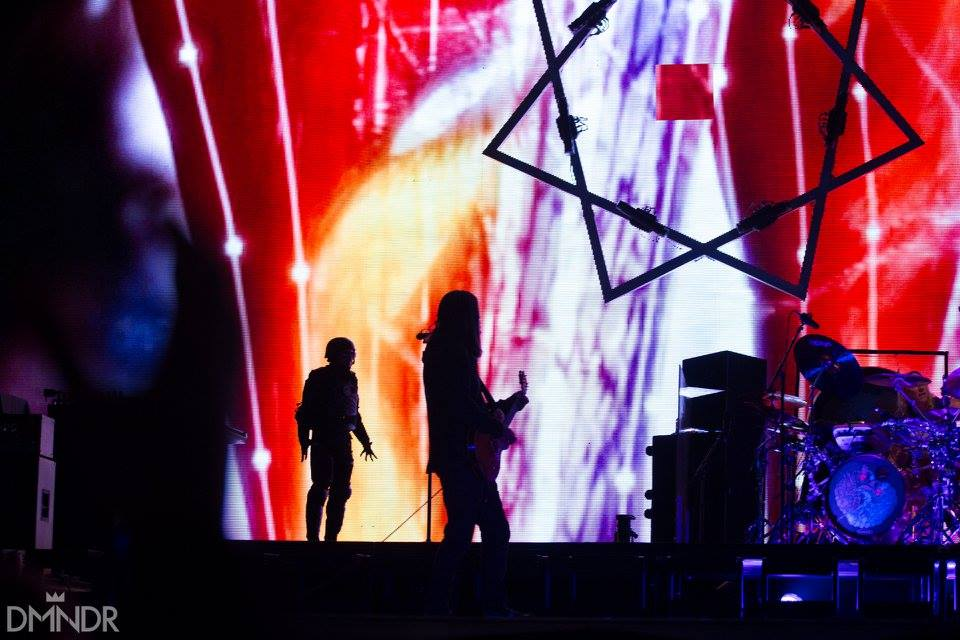</br> *Photo by [DMNDR](http://x.dmndr.com/boston-calling-dmndr-answers-the-complete-festival-photo-review/)*

In 2019, the critically acclaimed progressive-rock band Tool released the album Fear Inoculum after a 13-year hiatus between releases. Although Fear Inoculum came out prior to the covid-19 pandemic, the lyrics seem prescient at times. For example: the title track, Fear Inoculum, starts with "*Immunity, long overdue. Contagion, I exhale you*", a phrase that could easily apply to life during the pandemic.  Tool's vocalist, Maynard James Keenan, has long been lauded as an excellent lyricist. However, Tool fans are notorious for using messages boards to unpack and deciper the meaning conveyed by their songs, often to the chagrin of the [band](https://www.nme.com/news/music/tool-4-1204846). 

This notebook provides a Natural Language Processing pipeline for Tool's lyrics, which were extracted using [LyricsGenius](https://lyricsgenius.readthedocs.io/en/master/), a Python client for the Genius.com API. The process involves cleaning the extracted dataset and engineering features that will enable the lyrics be analysed using an NLP framework, such as [spaCy](https://spacy.io/) or [NLTK](https://www.nltk.org/). 

# Fetching the data

LyricsGenius is a Python client that allows users to easily extract data from Genius.com, a popular lyrics website. The Tool lyrics dataset was extracted using this method and saved to a github repository. For more information, please read the LyricsGenius [documentation](https://lyricsgenius.readthedocs.io/en/master/setup.html). 

The below code loads the .json file containing the data extracted via LyricsGenius. Viewing the data indicates that further parsing is required before NLP can be applied. 

In [ ]:
# fetch data from Github

import json 
import requests

url = "https://raw.githubusercontent.com/MatthewGuile/tool-lyrics-nlp/main/files/Lyrics_Tool.json"
resp = requests.get(url)
data = json.loads(resp.text)

# view data to determine what further processing is required
data

# Cleaning the data

Most of the data required is located in the 'songs' key of the dataset. 

In [17]:
# load 'song' key to pandas dataframe

import pandas as pd

df0 = pd.DataFrame(data['songs'])

# view keys to determine what further processing is required
df0.keys()

Index(['annotation_count', 'api_path', 'artist_names', 'full_title',
       'header_image_thumbnail_url', 'header_image_url', 'id',
       'lyrics_owner_id', 'lyrics_state', 'path', 'pyongs_count',
       'song_art_image_thumbnail_url', 'song_art_image_url', 'stats', 'title',
       'title_with_featured', 'url', 'primary_artist', 'apple_music_id',
       'apple_music_player_url', 'description', 'embed_content',
       'featured_video', 'lyrics_placeholder_reason', 'recording_location',
       'release_date', 'release_date_for_display', 'current_user_metadata',
       'album', 'custom_performances', 'description_annotation',
       'featured_artists', 'lyrics_marked_complete_by', 'media',
       'producer_artists', 'song_relationships', 'verified_annotations_by',
       'verified_contributors', 'verified_lyrics_by', 'writer_artists',
       'artist', 'lyrics'],
      dtype='object')

From the list of keys, save 'title', 'lyrics' and 'release_date" to a new dataframe.

In [18]:
# select relevant columns and save to new dataframe
df = df0[['title', 'lyrics', 'release_date']]

In order to add a column with the associated album names, it is necessary to extract the data from the df0['album'] key. This is done by retrieving the album names using a for loop to add them to a list, and then adding the list to a column. This initially presented with a warning from Pandas relating to [SettingWithCopyWarning](https://www.dataquest.io/blog/settingwithcopywarning/). However, further investigation indicated that this was a false positive and therefore the warning is bypassed. 

In [19]:
# scrape albums and add them to the new dataframe

pd.options.mode.chained_assignment = None # this bypasses the pandas SettingWithCopyWarning, which had a false positive 

album_list = []

for i in range(len(df0['album'])):
    try:
        album_list.append(df0['album'][i]['name'])
    except:
        album_list.append(None)
        continue


df['album'] = album_list

# view dataframe
df

,title,lyrics,release_date,album
0,Sober,There's a shadow just behind me\nShrouding eve...,1993-04-06,Undertow
1,Lateralus,Black\nThen\nWhite are\nAll I see\nIn my infan...,2001-05-15,Lateralus
2,Ænema,"Hey, hey, hey, hey, hey, hey, hey, hey, hey\n\...",1996-09-17,Ænima
3,Forty Six & 2,"Join in my—\nJoin in, my child, and listen\nDi...",1996-09-17,Ænima
4,The Pot,Who are you to wave your finger?\nYou must've ...,2006-05-02,"10,000 Days"
...,...,...,...,...
83,Ænema [Demo],"Hey, hey, hey, hey\n(hey, hey, hey, hey, hey, ...",1994-01-01,None
84,Crawl Away (Demo),Crawled away from me\nSlipped away from me\nTr...,1991-12-21,72826
85,Part of Me (Demo),"I know you well, you are a part of me\nI know ...",1991-12-21,72826
86,Flood (Live),All I knew and all I believed\nAre crumbling i...,None,Sober - Tales from the Darkside


The album column above contains demos and live albums, which means that there are duplicates of songs in the dataset. Subsequently, let's select the band's main six releases. Please note that the band's first release, Opiate, was an EP and thus contains fewer songs than the other releases. 





In [20]:
# select the albums required for analysis and drop irrelevant data
relevant_albums = ['Opiate', 'Undertow', 'Ænima', 'Lateralus', '10,000 Days', 'Fear Inoculum']

df = df[df['album'].isin(relevant_albums)]

# view dataframe 
df

,title,lyrics,release_date,album
0,Sober,There's a shadow just behind me\nShrouding eve...,1993-04-06,Undertow
1,Lateralus,Black\nThen\nWhite are\nAll I see\nIn my infan...,2001-05-15,Lateralus
2,Ænema,"Hey, hey, hey, hey, hey, hey, hey, hey, hey\n\...",1996-09-17,Ænima
3,Forty Six & 2,"Join in my—\nJoin in, my child, and listen\nDi...",1996-09-17,Ænima
4,The Pot,Who are you to wave your finger?\nYou must've ...,2006-05-02,"10,000 Days"
...,...,...,...,...
62,Part of Me,"Yeah\nReady\n\nI know you well, you are a part...",1992-03-10,Opiate
63,Lipan Conjuring,2EmbedShare URLCopyEmbedCopy,2006-05-02,"10,000 Days"
65,(-) Ions,,1996-09-17,Ænima
66,Cesaro Summability,EmbedShare URLCopyEmbedCopy,1996-09-17,Ænima


# Data cleaning continued 

In [ ]:
# data cleaning time wooohooo
import re
# remove whitespace

def remove_whitespace(text):
    """ This function will remove
        extra whitespaces from the text
    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after extra whitespaces removed .

    Example:
    Input : How   are   you   doing   ?
    Output : How are you doing ?

    """
    pattern = re.compile(r'\s+')
    Without_whitespace = re.sub(pattern, ' ', text)
    # There are some instances where there is no space after '?' & ')',
    # So I am replacing these with one space so that It will not consider two words as one token.
    text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return text

df['lyrics'] = df['lyrics'].apply(lambda x: remove_whitespace(x))

df

,title,lyrics,release_date,album
0,Sober,There's a shadow just behind me Shrouding ever...,1993-04-06,Undertow
1,Lateralus,Black Then White are All I see In my infancy R...,2001-05-15,Lateralus
2,Ænema,"Hey, hey, hey, hey, hey, hey, hey, hey, hey So...",1996-09-17,Ænima
3,Forty Six & 2,"Join in my— Join in, my child, and listen Digg...",1996-09-17,Ænima
4,The Pot,Who are you to wave your finger ? You must've...,2006-05-02,"10,000 Days"
...,...,...,...,...
62,Part of Me,"Yeah Ready I know you well, you are a part of ...",1992-03-10,Opiate
63,Lipan Conjuring,2EmbedShare URLCopyEmbedCopy,2006-05-02,"10,000 Days"
65,(-) Ions,,1996-09-17,Ænima
66,Cesaro Summability,EmbedShare URLCopyEmbedCopy,1996-09-17,Ænima


In [ ]:
def lower_casing_text(text):
    """
    The function will convert text into lower case.

    arguments:
         input_text: "text" of type "String".

    return:
         value: text in lowercase

    Example:
    Input : The World is Full of Surprises!
    Output : the world is full of surprises!

    """
    # Convert text to lower case
    # lower() - It converts all upperase letter of given string to lowercase.
    text = text.lower()
    return text

df['lyrics'] = df['lyrics'].apply(lambda x: lower_casing_text(x))

df.head()

,title,lyrics,release_date,album
0,Sober,there's a shadow just behind me shrouding ever...,1993-04-06,Undertow
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus
2,Ænema,"hey, hey, hey, hey, hey, hey, hey, hey, hey so...",1996-09-17,Ænima
3,Forty Six & 2,"join in my— join in, my child, and listen digg...",1996-09-17,Ænima
4,The Pot,who are you to wave your finger ? you must've...,2006-05-02,"10,000 Days"


In [ ]:
# fix contractions 

CONTRACTION_MAP = {
    "'bout": "about",
    "ain't": "is not",
    "'round": "around",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "get'chu": "get you",
    "gonna": "going to",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "kinda": "kind of",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "l.a": "los angeles",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "'til": "until",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "whatcha": "what are you",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}


# The code for expanding contraction words
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    """expand shortened words to the actual form.
       e.g. don't to do not

       arguments:
            input_text: "text" of type "String".

       return:
            value: Text with expanded form of shorthened words.

       Example:
       Input : ain't, aren't, can't, cause, can't've
       Output :  is not, are not, cannot, because, cannot have

     """
    # Tokenizing text into tokens.
    list_Of_tokens = text.split(' ')

    # Checking for whether the given token matches with the Key & replacing word with key's value.

    # Check whether Word is in lidt_Of_tokens or not.
    for Word in list_Of_tokens:
        # Check whether found word is in dictionary "Contraction Map" or not as a key.
        if Word in CONTRACTION_MAP:
            # If Word is present in both dictionary & list_Of_tokens, replace that word with the key value.
            list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]

    # Converting list of tokens to String.
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens)
    return String_Of_tokens

df['lyrics'] = df['lyrics'].apply(lambda x: expand_contractions(x, contraction_mapping=CONTRACTION_MAP))

df.head(5)




,title,lyrics,release_date,album
0,Sober,there is a shadow just behind me shrouding eve...,1993-04-06,Undertow
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus
2,Ænema,"hey, hey, hey, hey, hey, hey, hey, hey, hey so...",1996-09-17,Ænima
3,Forty Six & 2,"join in my— join in, my child, and listen digg...",1996-09-17,Ænima
4,The Pot,who are you to wave your finger ? you must ha...,2006-05-02,"10,000 Days"


In [ ]:
# The code for removing special characters
def removing_special_characters(text):
    """Removing all the special characters except the one that is passed within
       the regex to match, as they have imp meaning in the text provided.


    arguments:
         input_text: "text" of type "String".

    return:
        value: Text with removed special characters that don't require.

    Example:
    Input : Hello, K-a-j-a-l. Thi*s is $100.05 : the payment that you will recieve! (Is this okay?)
    Output :  Hello, Kajal. This is $100.05 : the payment that you will recieve! Is this okay?

   """
    # The formatted text after removing not necessary punctuations.
    Formatted_Text = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text)
    Remove_Characters = re.sub(r"[0-9]+[a-zA-Z]+ [a-zA-Z]+",'', Formatted_Text)
    Remove_More_Characters = Remove_Characters.replace("embedshare urlcopyembedcopy", "")
    
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return Remove_More_Characters

df['lyrics'] = df['lyrics'].apply(lambda x: removing_special_characters(x))

df

,title,lyrics,release_date,album
0,Sober,there is a shadow just behind me shrouding eve...,1993-04-06,Undertow
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus
2,Ænema,"hey, hey, hey, hey, hey, hey, hey, hey, hey so...",1996-09-17,Ænima
3,Forty Six & 2,"join in my join in, my child, and listen diggi...",1996-09-17,Ænima
4,The Pot,who are you to wave your finger ? you must hav...,2006-05-02,"10,000 Days"
...,...,...,...,...
62,Part of Me,"yeah ready i know you well, you are a part of ...",1992-03-10,Opiate
63,Lipan Conjuring,,2006-05-02,"10,000 Days"
65,(-) Ions,,1996-09-17,Ænima
66,Cesaro Summability,,1996-09-17,Ænima


In [ ]:
import string as st

# Remove punctuation
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

df['lyrics'] = df['lyrics'].apply(lambda x: remove_punct(x))

df

,title,lyrics,release_date,album
0,Sober,there is a shadow just behind me shrouding eve...,1993-04-06,Undertow
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus
2,Ænema,hey hey hey hey hey hey hey hey hey some say t...,1996-09-17,Ænima
3,Forty Six & 2,join in my join in my child and listen digging...,1996-09-17,Ænima
4,The Pot,who are you to wave your finger you must have...,2006-05-02,"10,000 Days"
...,...,...,...,...
62,Part of Me,yeah ready i know you well you are a part of m...,1992-03-10,Opiate
63,Lipan Conjuring,,2006-05-02,"10,000 Days"
65,(-) Ions,,1996-09-17,Ænima
66,Cesaro Summability,,1996-09-17,Ænima


In [ ]:
# feature engineering

lyrics = df[["title", 'lyrics', "release_date", 'album']].copy()


lyrics['word_count'] = lyrics['lyrics'].apply(lambda x : len(x.split()))
lyrics['unique_count'] = lyrics['lyrics'].apply(lambda x: len(set(w for w in x.split())))
lyrics['lexical_diversity'] = lyrics['unique_count'] / lyrics['word_count']
lyrics = lyrics.loc[lyrics.word_count > 0]
lyrics.head()


lyrics.sort_values('unique_count', ascending=False)



,title,lyrics,release_date,album,word_count,unique_count,lexical_diversity
9,Rosetta Stoned,alrighty then picture this if you will 10 to 2...,2006-05-02,"10,000 Days",707,266,0.376238
39,Disgustipated,and the angel of the lord came unto me snatchi...,1993-04-06,Undertow,552,212,0.384058
16,Third Eye,see i think drugs have done some good things ...,1996-09-17,Ænima,560,202,0.360714
7,"10,000 Days (Wings Pt 2)",we listen to the tales and romanticize how we ...,2006-05-02,"10,000 Days",402,189,0.470149
2,Ænema,hey hey hey hey hey hey hey hey hey some say t...,1996-09-17,Ænima,576,164,0.284722
20,Eulogy,he had a lot to say he had a lot of nothing to...,1996-09-17,Ænima,424,155,0.365566
15,Vicarious,eye on the tv because tragedy thrills me whate...,2006-05-02,"10,000 Days",332,154,0.463855
24,Pushit,i saw the gap again today while you were beggi...,1996-09-17,Ænima,427,136,0.318501
18,Jambi,here from the kings mountain view here from th...,2006-05-02,"10,000 Days",315,135,0.428571
1,Lateralus,black then white are all i see in my infancy r...,2001-05-15,Lateralus,333,132,0.396396


In [ ]:
# lyrics.dtypes # need to convert release date to datetime format

# albums_wordcount = lyrics[['album','word_count']].groupby('album').describe()

# albums_wordcount['release_date'] = lyrics.loc[lyrics.release_date = 0]
# albums_wordcount = albums_wordcount.sort_values('release_date')
# albums_wordcount

SyntaxError: ignored

<class 'pandas.core.series.Series'>


In [ ]:
# albums_uw = lyrics[['Album','unique_count']].groupby("Album").describe()
# albums_uw["released"] = [2015,2009,2013,2005,2017,2007,2011,2003]
# albums_uw = albums_uw.sort_values('released')
# albums_uw

In [ ]:
# albums_diversity = lyrics[['Album','lexical_diversity']].groupby("Album").describe()
# albums_diversity["released"] = [2015,2009,2013,2005,2017,2007,2011,2003]
# albums_diversity = albums_diversity.sort_values('released')
# albums_diversity